# Officer-Involved Shootings - Dallas, TX
`Author: John Salisbury / Last Updated: Apr 8, 2023`
***

![Map of Dallas and SQL code](../img/dallas_shootings_cover.jpg)

***
## (1) Summary

This exploratory analysis **uses SQL and Python to examine officer-involved shootings** in Dallas, TX between 2003-2016.

I came across this interesting dataset while looking for public-facing SQLite databases to work with (credit to Stanford's [Public Affairs Data Journalism website](http://2016.padjo.org/tutorials/sqlite-data-starterpacks/) for a great list of public data!). It takes the form of a SQLite database with three tables that describe shootings in which officers from the Dallas Police Department were involved. The data can also be found on the city of Dallas's [open data portal](https://www.dallasopendata.com/Public-Safety/Dallas-Police-Officer-Involved-Shootings/4gmt-jyx2).

In this analysis, I use SQL to explore and calculate summary statistics for the entire dataset. I then feed the data into Python's `folium` module to generate interactive maps that allow us to explore officer-involved shootings in a spatial context. 

Let's get started!

--
<br><br>
*Table of Contents:*
<br>
<a href="#modules" class="toc">Import Modules and Data</a>
<br>
<a href="#database-structure" class="toc">Database Structure</a>
<br>
<a href="#explore-data" class="toc">Exploring Officer-Involved Shootings</a>
<br>
<a href="#all-shootings" class="nest-one toc">All Shootings</a>
<br>
<a href="#all-shootings-race" class="nest-two toc">By Subject Race</a>
<br>
<a href="#all-shootings-gender" class="nest-two toc">By Subject Gender</a>
<br>
<a href="#fatal-shootings" class="nest-one toc">Fatal Shootings</a>
<br>
<a href="#fatal-shootings-race" class="nest-two toc">By Subject Race</a>
<br>
<a href="#fatal-shootings-gender" class="nest-two toc">By Subject Gender</a>
<br>
<a href="#annual-trends" class="nest-one toc">Annual Trends</a>
<br>
<a href="#locations" class="nest-one toc">Locations</a>
<br>
<a href="#location-point-map" class="nest-two toc">Point Map</a>
<br>
<a href="#location-heatmap" class="nest-two toc">Heatmap</a>
<br>
<a href="#insights" class="toc">Insights</a>

--

*Find the data for this project below:*
<br>
[DPD Officer-Involved Shooting Data](https://www.dallasopendata.com/Public-Safety/Dallas-Police-Officer-Involved-Shootings/4gmt-jyx2)

<div id="modules"></div>

***
## (2) Import Modules and Data

### Modules
To start our analysis, we first **import a number of Python modules** that we'll use to process and visualize the data we pull from our local SQLite database file:

In [145]:
#IMPORT MODULES ------

#Common modules
import pandas as pd #Dataframe support
import matplotlib.pyplot as plt   #Plotting support

#Statistics
from statsmodels.stats.proportion import proportions_ztest

#SQL
import sqlalchemy
from sqlalchemy import create_engine

#Mapping
import folium
from folium.plugins import HeatMap

#IPython - HTML notebook formatting
from IPython.core.display import HTML

#Suppress warnings in notebook
import warnings
warnings.filterwarnings('ignore')

Next, we'll **enable Jupyter's SQL "magic"**, which will allow us to run SQL queries in the notebook cells below:

In [2]:
%load_ext sql

And finally, we'll add some custom CSS to improve the look and feel of our notebook:

In [142]:
#Add custom CSS to center output PNGs
HTML("""
<style>
.jp-needs-light-background {
    display: block;
    margin: auto;
}

.jp-OutputArea-output.jp-RenderedHTMLCommon table {
    margin: 2em auto;
    background: #eae9e9;
    border: 1px solid #000;
    font-size: 14px;
}

.toc {
    font-size: 16px;
}

.nest-one {
    margin-left: 1em;
    font-style: italic;
    font-size: 14px;
}

.nest-two {
    margin-left: 3em;
    font-style: italic;
    font-size: 12px;
}

.faint {
    opacity: 0.2;
}
</style>
""")

### Data

Next, we'll **connect to our SQLite database**, which is really just a local SQLite file stored in a separate directory:

In [4]:
%sql sqlite:///../data/dallas-ois.sqlite

That's it! We're now ready to explore this data.

<div id="database-structure"></div>

***
## (3) Database Structure

The first step in our process is to **explore the structure our database**. We can see what tables are contained within the database with the query below:

In [5]:
%%sql

SELECT
    name "Table Name" 
FROM
    sqlite_schema 
WHERE
    type='table' 
ORDER BY
    name;

 * sqlite:///../data/dallas-ois.sqlite
Done.


Table Name
incidents
officers
subjects


<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Table 1</b>. Tables contained with SQLite database.</p>
<br><br>

As visualized in *Table 1* above, it looks like we have **three tables** in our database - `incidents`, `officers`, and `subjects`. Using metadata from the city of Dallas's open data portal, we can determine that each table contains the following data:
- `incidents` - detailed data (including date, location, weapons recovered, subject status, officers involved, and police blotter summaries) on individual officer-involved shootings in Dallas, TX between 2003-2016
- `officers` - demographic and personal data on all Dallas police officers involved in a shooting between 2003-2016
- `subjects` - demographic and personal data (when available) on all individuals who were the subject of an officer-involved shooting between 2003-2016

The three tables are linked together by the `case_number` column, which is a unique identifier assigned to each shooting. We can use the free tool [Lucidchart](https://lucidchart.com) to create a simple schema for our database:

![Database Schema](../data/db_schema.png)

<div id="explore-data"></div>

***
## (4) Exploring Officer-Involved Shootings (2013-2016)

Now that we understand the structure of our database, let's do some **basic exploratory data analysis**.

To facilitate our analysis, we'll first **create a view of our data** that we can further process and aggregate in multiple subsequent queries. In the SQL query below, we create this view by performing the following operations:
- Join the `incidents` and `subjects` tables on the `case_number` column (which serves as our primary key) - this gives us access to the `race` data of each shooting subject contained within the `subjects` table
- Group the resulting table by the `year`, `subject_statuses`, `race`, and `gender` variables (which will allow us to flexibly perform a number of aggregations later on in our analysis)
- Count the number of incidents within the resulting table (and alias this as `shootings`)
- Create a new column (`year`) to which we extract the years represented in our data


In [6]:
%%sql

CREATE VIEW annual_shootings AS 
SELECT
   SUBSTR(STRFTIME('%Y-%m-%d', ic.date), 1, 4) year,
   COUNT(*) shootings,
   ic.subject_statuses outcome,
   sb.race,
   sb.gender 
FROM
   incidents ic 
   INNER JOIN
      subjects sb 
      ON sb.case_number = ic.case_number 
GROUP BY
   year,
   ic.subject_statuses,
   sb.race,
   sb.gender;

 * sqlite:///../data/dallas-ois.sqlite
Done.


[]

<hr class="faint">

<div id="all-shootings"></div>

### All Shootings
First, let's **summarize all officer-involved shootings** that took place in Dallas, TX between 2003-2016:

In [8]:
%%sql

WITH annual_stats AS 
(
   SELECT
      year,
      SUM(shootings) shootings 
   FROM
      annual_shootings 
   GROUP BY
      year 
)
SELECT
   SUM(shootings) "Total Shootings",
   ROUND(CAST(SUM(shootings) AS Float) / COUNT(DISTINCT(year)), 1) "Avg. Shootings Per Year",
   MAX(shootings) "Max Shootings Per Year",
   MIN(shootings) "Min Shootings Per Year" 
FROM
   annual_stats;

 * sqlite:///../data/dallas-ois.sqlite
Done.


Total Shootings,Avg. Shootings Per Year,Max Shootings Per Year,Min Shootings Per Year
223,15.9,24,8


<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Table 2</b>. Summary of officer-involved shootings in Dallas, TX between 2003-2016.</p>
<br><br>

In the table above, can see that there were 223 officer-involved shootings between 2003-2016, with an average of 15.9 shootings per year. The highest number of shootings in a given year during this time period was 24, whereas the lowest number of shootings in a given year was eight.

<hr class="faint">

<div id="all-shootings-race"></div>

#### By Subject Race
Next, let's **break these metrics down by subject race** (i.e., the perceived race of the individual who was the subject of each officer-involved shooting):

In [11]:
%%sql

SELECT
    race "Race",
    SUM(shootings) "Total Shootings",
    ROUND(CAST(SUM(shootings) AS Float) / (    SELECT
        SUM(shootings)     
    FROM
        annual_shootings),
    2)*100 " % of Total"     
FROM
    annual_shootings     
GROUP BY
    race;

 * sqlite:///../data/dallas-ois.sqlite
Done.


Race,Total Shootings,% of Total
A,2,1.0
B,111,50.0
L,72,32.0
W,38,17.0


<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Table 3</b>. Total number and relative percentage of officer-involved shootings in Dallas, TX between 2003-2016 within four racial groups. "A" refers to "Asian", "B" refers to "Black", "L" refers to "Latino", and "W" refers to "White", as defined by the Dallas Police Department.</p>
<br><br>

In *Table 3* above, we can see that roughly **50% of officer-involved shootings** between 2003-2016 **involved Black subjects**, whereas **32% of shootings involved Latino subjects** and **17% involved White subjects**. In contrast, only **1% of shootings involved Asian subjects**.

**One Sample Proportion Test**

According to [2010 US Census Bureau data](https://www.census.gov/quickfacts/fact/dashboard/dallascitytexas/RHI225221#RHI225221), we can see that the city of Dallas had a population that was 24.0% Black, 42.0% Hispanic or Latino, 28.6% White, and 3.5% Asian in 2010 (with the other 5.4% identifying as American Indian or undefined race). Compared to the data in *Table 3*, it seems that the Black population in Dallas may be overrepresented in officer-involved shootings, whereas the Latino, White, and Asian populations could be underrepresented.

We can quickly **test this hunch using a *one sample proportion test***. We can define $p$ (our observed sample proportion, or rather, the proportion of officer-involved shootings with a Black subject) as 0.5. In contrast, $p_0$ (our theoretical population proportion, or in this case, the proportion of Dallas's population that identifies as Black) as 0.24. Our sample size, $n$, is the total number of shootings in our dataset (223).

In this test, our null hypothesis is $p = p_0$ (or that there is no difference between the proportion of officer-involved shootings with a Black subject and the proportion of Dallas's population that identifies as Black. To run this test, we'll use the `proportions_ztest()` function from the `statsmodels` library. This will return a p-value along with our test statistic that will allow us to determine if there is a significant difference between the two proportions.

In [146]:
proportions_ztest(count=111, nobs=223, value=0.24)

(7.698368402575708, 1.3781456281035084e-14)

We see that our p-value (the second value in the tuple above) is $p=1.378e^{-14}$. This suggests that there is a significant difference between $p$ (the proportion of officer-involved shootings with a Black subject) and $p_0$ (the proportion of Dallas's population that identifies as Black). In simpler terms, the results of our statistical test suggest that Black individuals who live in Dallas were significantly overrepresented in officer-involved shootings between 2003-2016.

<hr class="faint">

<div id="all-shootings-gender"></div>

#### By Subject Gender
Let's also **break these metrics down by subject gender** (i.e., the perceived gender of the individual who was subject to police shooting):

In [12]:
%%sql

SELECT
    gender "Gender",
    SUM(shootings) "Total Shootings",
    ROUND(CAST(SUM(shootings) AS Float)/223,
    2)*100 "% of Total"   
FROM
    annual_shootings 
GROUP BY
    gender;

 * sqlite:///../data/dallas-ois.sqlite
Done.


Gender,Total Shootings,% of Total
F,8,4.0
M,215,96.0


<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Table 4</b>. Total number and relative percentage of officer-involved shootings in Dallas, TX between 2003-2016 within two gender groups. "F" refers to "female" and "M" refers to "male", as defined by the Dallas Police Department. Other gender options were not included in the original dataset.</p>
<br><br>

It appears that males were the subjects in a majority (96%) of officer-involved shootings, whereas very few shootings (4%) had female subjects.

<hr class="faint">

<div id="fatal-shootings"></div>

### Fatal Shootings
Next, let's move on to **_fatal_ officer-involved shootings** (i.e., shootings that resulted in the death of the individual who was subject to the shooting). To help us explore these specific shootings in the queries below, we'll **create another view** of our data in which we filter down to fatal shootings:

In [13]:
%%sql

CREATE VIEW fatal_shootings AS 
    SELECT
       year,
       race,
       gender,
       SUM(shootings) shootings 
FROM
   annual_shootings 
WHERE
   outcome = "Deceased" 
GROUP BY
   year,
   race,
   gender;

 * sqlite:///../data/dallas-ois.sqlite
Done.


[]

Now we can **summarize all _fatal_ officer-involved shootings** that took place in Dallas, TX between 2003-2016:

In [14]:
%%sql
SELECT
    SUM(shootings) "Total Fatal Shootings",
    ROUND(CAST(SUM(shootings) AS Float) / COUNT(DISTINCT(year)),
    1) "Avg. Fatal Shootings Per Year",
    MAX(shootings) "Max Fatal Shootings Per Year",
    MIN(shootings) "Min Fatal Shootings Per Year"   
FROM
    fatal_shootings;

 * sqlite:///../data/dallas-ois.sqlite
Done.


Total Fatal Shootings,Avg. Fatal Shootings Per Year,Max Fatal Shootings Per Year,Min Fatal Shootings Per Year
69,4.9,7,1


<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Table 5</b>. Summary of fatal officer-involved shootings in Dallas, TX between 2003-2016.</p>
<br><br>

It looks like there were 69 officer-involved shootings that resulted in death between 2003-2016, indicating that roughly 31% of all officer-involved shootings during this time were fatal. On average, there were roughly 4.9 fatal shootings per year. The highest number of fatal shootings in a given year during this time period was seven, whereas the lowest number of fatal shootings in a given year was just one.

<hr class="faint">

<div id="fatal-shootings-race"></div>

#### By Subject Race
Let's **break these metrics down by subject race**, as we did earlier:

In [15]:
%%sql

SELECT
    race "Race",
    SUM(shootings) "Fatal Shootings",
    ROUND(CAST(SUM(shootings) AS Float)/(SELECT
        SUM(shootings) 
    FROM
        fatal_shootings),
    2)*100 "% of Total"   
FROM
    fatal_shootings 
GROUP BY
    race;

 * sqlite:///../data/dallas-ois.sqlite
Done.


Race,Fatal Shootings,% of Total
B,34,49.0
L,13,19.0
W,22,32.0


<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Table 6</b>.
Total number and relative percentage of officer-involved shootings in Dallas, TX between 2003-2016 within three racial groups. "B" refers to "Black", "L" refers to "Latino", and "W" refers to "White", as defined by the Dallas Police Department.</p>
<br><br>

We can see that roughly 49% of fatal officer-involved shootings between 2003-2016 involved Black subjects, whereas 32% involved Latino subjects and and 17% involved White subjects. No fatal shootings during this time period involved Asian subjects.

<hr class="faint">

<div id="fatal-shootings-gender"></div>

#### By Subject Gender
Additionally, **we can break these metrics down by subject gender**:

In [16]:
%%sql

SELECT
    gender "Gender",
    SUM(shootings) "Fatal Shootings",
    ROUND(CAST(SUM(shootings) AS Float)/(SELECT
        SUM(shootings) 
    FROM
        fatal_shootings),
    2)*100 "% of Total"   
FROM
    fatal_shootings 
GROUP BY
    gender;

 * sqlite:///../data/dallas-ois.sqlite
Done.


Gender,Fatal Shootings,% of Total
F,2,3.0
M,67,97.0


<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Table 7</b>. Total number and relative percentage of fatal officer-involved shootings in Dallas, TX between 2003-2016 within two gender groups. "F" refers to "female" and "M" refers to "male", as defined by the Dallas Police Department. Other gender options were not included in the original dataset.</p>
<br><br>

Similar to total shootings, we see that males were subjects in a majority (97%) of fatal officer-involved shootings between 2003-2016. In contrast, females were subjects in only 3% of fatal shootings.

<hr class="faint">

<div id="annual-trends"></div>

### Annual Trends
Above, we've looked at summary statistics for the entire time period of our dataset. However, it might be interesting to **look at officer-involved shootings on an annual basis** to determine how they varied in frequency from year to year between 2003-2016. For this step of the analysis, we will pass the results of an SQL query to a `pandas` dataframe object that we can then plot using `matplotlib`.

To accomplish this, we use the `sqlalchemy` module to create a new connection to our SQLite database:

In [17]:
#Create another connection to SQLite file 
sql_engine = create_engine('sqlite:///../data/dallas-ois.sqlite', echo=False)
conn = sql_engine.raw_connection()

We then pass this connection (along with our desired SQL query) to Pandas' `read_sql_query()` function, saving the results as a dataframe:

In [18]:
#Save SQL query to pandas dataframe
ann_trends = pd.read_sql_query(
    """
    WITH ann_sums AS 
        (
           SELECT
              year,
              SUM(shootings) shootings 
           FROM
              annual_shootings 
           GROUP BY
              year 
        ),
    ann_fats AS 
        (
           SELECT
              year,
              SUM(shootings) shootings 
           FROM
              fatal_shootings 
           GROUP BY
              year 
        )
        
    SELECT
       ans.year,
       ans.shootings tot_shootings,
       afs.shootings fat_shootings
    FROM
       ann_fats afs 
    INNER JOIN
       ann_sums ans 
       ON ans.year = afs.year;
    """, con = conn)

Below, we'll generate a time series plot that displays the total number of officer-involved shootings between 2003-2016, as well the number of *fatal* shootings during that time period. We will also display rolling averages for each variable.

In [38]:
#Generate a rolling average column for total shootings
ann_trends["tot_shootings_roll"] = ann_trends["tot_shootings"].rolling(window=3, center=True).mean()

#Generate a rolling average column for fatal shootings
ann_trends["fat_shootings_roll"] = ann_trends["fat_shootings"].rolling(window=3, center=True).mean()

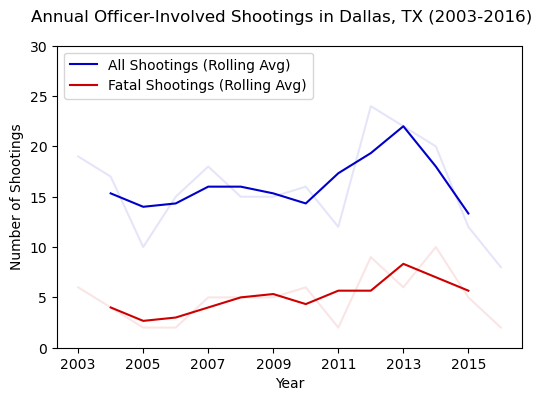

In [119]:
#Generate a time series plot
plt.figure(figsize=(6,4), dpi=100)
plt.plot(ann_trends['year'], ann_trends['tot_shootings_roll'], label="All Shootings (Rolling Avg)", color="#0000ca")
plt.plot(ann_trends['year'], ann_trends['tot_shootings'], color="#0000ca", alpha=0.1)
plt.plot(ann_trends['year'], ann_trends['fat_shootings_roll'], label="Fatal Shootings (Rolling Avg)", color="#cd0000")
plt.plot(ann_trends['year'], ann_trends['fat_shootings'], color="#cd0000", alpha=0.1)
plt.suptitle("Annual Officer-Involved Shootings in Dallas, TX (2003-2016)", fontsize=12, y=0.97)
plt.xlabel("Year")
plt.xticks(["2003", "2005", "2007", "2009", "2011", "2013", "2015"])
plt.ylabel("Number of Shootings")
plt.yticks([0,5,10,15,20,25, 30])
plt.legend(loc="upper left")
plt.show()

<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Figure 1</b>. Rolling averages of all (blue) and fatal (red) officer-involved shootings in Dallas, TX between 2003-2016 (k=3). Transparent blue and red lines indicate annual totals for all shootings and fatal shootings, respectively.</p>
<br><br>

As seen in *Figure 1* above, we can see that the number of officer-involved shootings per year peaked between 2012-2013, but decreased sharply in subsequent years. Fatal shootings seem to have followed a similar trend, peaking in 2014 but dropping substantially in 2015-2016.

Next, let's explore shootings spatially by plotting them on a map of Dallas. First, however, let's go ahead and drop the custom views of our data that we previously created, as we no longer need them:

In [ ]:
%%sql
DROP VIEW annual_shootings;
DROP VIEW fatal_shootings;

<hr class="faint">

<div id="locations"></div>

### Locations

Where in Dallas did officer-involved shootings take place between 2003-2016? Can we identify clusters in which shootings were more frequent? Let's use the `folium` module to **create an interactive map of these shootings within Dallas city limits**.

We can use Pandas' `read_sql_query()` function again to pull latitude and longitude coordinates for each shooting incident from our SQL database. We'll also pull the date and subject outcome (e.g., death, injury, etc.) for each shooting so that we can include this information in our map:

In [53]:
#Save latitude and longitude values for each shooting into a dataframe
locs = pd.read_sql_query("SELECT date, subject_statuses, latitude, longitude FROM incidents", con = conn)

We've loaded this data into a Pandas dataframe. Now let's check if the dataset has any missing values:

In [55]:
#Explore missing values
locs[locs["latitude"].isna()]

,date,subject_statuses,latitude,longitude
0,2013-02-23,Injured,NaN,NaN
1,2010-05-03,Injured,NaN,NaN
2,2007-08-12,Other,NaN,NaN
3,2007-05-26,Shoot and Miss,NaN,NaN
4,2006-04-03,Injured,NaN,NaN
5,2005-05-09,Shoot and Miss,NaN,NaN
6,2003-07-24,Deceased,NaN,NaN


It looks like there are seven shootings between 2003-2013 for which there is no latitude or longitude. This isn't ideal, but we'll go ahead and drop these rows from our dataframe:

In [60]:
#Remove NaN values from dataframe
locs_filt = locs.dropna(axis=0)

We should also verify that there are no erroneous data points in our other columns. Let's check out the `subject_statuses` column:

In [61]:
#What types of "subject statuses" do we have?
statuses = locs_filt["subject_statuses"].unique()
statuses

array(['Deceased', 'Shoot and Miss', 'Injured', 'Other',
       '1 Deceased 1 Injured', '2 Injured', 'Deceased Injured'],
      dtype=object)

In [62]:
locs_filt["subject_statuses"].value_counts()

Shoot and Miss          81
Deceased                67
Injured                 59
Other                    2
1 Deceased 1 Injured     1
2 Injured                1
Deceased Injured         1
Name: subject_statuses, dtype: int64

It looks like we have a few outliers that were possibly categorized incorrectly (i.e., the observations categorized under "1 Deceased 1 Injured", "2 Injured", and "Deceased Injured"). Because there are only three observations that fit within these categories, we can probably recategorize these observations into the other levels of `subject_statuses` without radically altering the data:

In [63]:
#Recategorize outlier statuses
locs_filt["subject_statuses"][(locs_filt["subject_statuses"] == statuses[-3]) | (locs_filt["subject_statuses"] == statuses[-1])] = "Deceased"
locs_filt["subject_statuses"][locs_filt["subject_statuses"] == statuses[-2]] = "Injured"
locs_filt["subject_statuses"].value_counts()

Shoot and Miss    81
Deceased          69
Injured           60
Other              2
Name: subject_statuses, dtype: int64

All observations are now categorized into four main levels of `subject_statuses`, which will simplify visualization of this data on our map below.

Let's go ahead and assign some colors to each level of `subject_statuses` for plotting purposes - this will help us to differentiate between shootings with different outcomes on our map:

In [134]:
#Assign colors in new column
locs_filt["colors"] = ''
locs_filt["colors"][locs_filt["subject_statuses"] == "Other"] = "#cfcfcf"
locs_filt["colors"][locs_filt["subject_statuses"] == "Shoot and Miss"] = "green"
locs_filt["colors"][locs_filt["subject_statuses"] == "Deceased"] = "red"
locs_filt["colors"][locs_filt["subject_statuses"] == "Injured"] = "gold"

We'll also assign an opacity value (between 0 and 1) to each of our observations based on what year it occurred in. This will make shootings that were more recent in our dataset appear more prominently on the map. To produce an opacity value for each observation, we create a `year` column (representing the year in which each shooting took place) and normalize that column to values between 0 and 1:

In [113]:
#Create an opacity column based on year
locs_filt["year"] = pd.to_numeric(locs_filt["date"].str.split('-').str[0])
locs_filt["opacity"]=(locs_filt["year"]-(locs_filt["year"].min()-2.5))/((locs_filt["year"].max()+2.5)-(locs_filt["year"].min()-2.5))

<hr class="faint">

<div id="location-point-map"></div>

#### Point Map
Now, we are **ready to create our map** of officer-involved shootings between 2003-2016!

We can use the `folium` module to create a base map of Dallas and add markers for each observation. Note that the color of each marker corresponds to a level in `subject_statuses` - red indicates a fatal shooting, yellow indicates a shooting that resulted in injury, and green indicates a "shoot and miss". Additionally, the opacity of each marker represents the year in which the shooting occurred (with transparent markers indicating "old" shootings and opaque markers indicating "recent" shootings):

In [136]:
#Define a basemap
m1 = folium.Map(location=[32.766328, -96.787865],
               tiles = 'CartoDB positron',
               zoom_start = 11,
               max_zoom = 13,
               min_zoom = 11)

#Define initial bounding box to show all data when user loads map
m1.fit_bounds(bounds=[[32.601042, -96.973948],[33.051101, -96.583247]])

#Add markers to map with positions, tooltips, and colors based on shooting data
def add_markers(x):
    folium.vector_layers.CircleMarker(location=[x["latitude"], x["longitude"]],
                                      radius=6,
                                      tooltip=x["subject_statuses"] + ' (' + str(x['year']) + ')',
                                      fill=True,
                                      fill_color=x["colors"],
                                      fill_opacity=x["opacity"],
                                      color=False).add_to(m1)
    
locs_filt.apply(add_markers, axis=1)

#Display map
m1

<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Figure 2</b>. Officer-involved shootings in Dallas, TX between 2009-2016. Each point represents a shooting. The color of each point represents the outcome of the shooting, with red, orange, and blue points indicate outcomes of death, injury, and "shoot and miss", respectively. The opacity of each point represents year of shooting, with more recent shootings having higher opacity.</p>
<br><br>

In *Figure 2* above, we see that officer-involved shootings were spread throughout the Dallas metro area between 2003-2016. We get the sense that certain areas of the city have had more shootings than others (such as downtown Dallas), but the large number of points makes it difficult to identify distinct clusters.

<hr class="faint">

<div id="location-heatmap"></div>

#### Heatmap
To deal with this difficulty in identifying clusters, we can **create a heatmap of shootings** between 2003-2016 using the `HeatMap()` function. This heatmap helps us to visualize the density of shootings within certain areas of the Dallas metro area as color gradients. We lose the ability to discern between shooting outcome (i.e., injury, death, etc.) and date, but we are now able to better visualize clusters of shootings across the city. 

In [120]:
#Define a map centered over Dallas, TX
m2 = folium.Map(location=[32.766328, -96.787865],
               tiles = 'CartoDB positron',
               zoom_start = 11,
               max_zoom = 12,
               min_zoom = 11)

#Define initial bounding box to show all data when user loads map
m2.fit_bounds(bounds=[[32.601042, -96.973948],[33.051101, -96.583247]])

#Generate a heat map from point data and add to map
HeatMap(locs_filt.iloc[:,-5:-3]).add_to(m2)

#Display map
m2

<p style="text-align: center; font-size: 12px; max-width: 800px; margin: auto"><b>Figure 3</b>. Heatmap of all officer-involved shootings in Dallas, TX between 2009-2016. Red areas and blue areas have relatively high and low densities of shootings, respectively.</p>
<br><br>

Exploring the map above, we can **identify several potential clusters** in which there was a relatively high density of shootings, including:
- Downtown Dallas
- 10200 Block of Walton Walker Blvd (northwest of downtown)
- South Dallas neighborhood (southwest of downtown)

However, it is again clear that officer-involved shootings took place over a really wide area across the city. A dedicated clustering analysis (using methods like k-means clustering) could be more effective in identifying meaningful spatial clusters of shootings.

<div id="insights"></div>

***
## (5) Insights

> #### Trends
There were 223 officer-involved shootings in Dallas, TX between 2003-2016, 31% of which resulted in one or more fatalities (*Tables 2 and 5*). On average, there were roughly 16 officer-involved shootings and five fatal shootings per year during this time period. Both total and fatal shootings peaked in 2012-2013 and then decreased in subsequent years (*Figure 1*).
>
> In contrast to Dallas, the city of Austin, TX - a [similarly sized](https://worldpopulationreview.com/states/cities/texas) Texas city - had just 90 officer-involved shootings between 2003-2016, roughly 40% of the number of shootings in Dallas. Additionally, Austin had just 34 shootings that resulted in one or more fatalities, roughly 49% of the number of fatal shootings in Dallas.
>
>*Source*: [City of Austin Open Data Portal](https://data.austintexas.gov/browse?q=officer%20involved%20shooting&sortBy=relevance)

> #### Race
Black individuals were identified as subjects in roughly 50% of officer-involved shootings in Dallas, TX between 2003-2016, whereas Latino (as defined by the dataset), White, and Asian individuals were identified as subjects in 32%, 17%, and 1% of all shootings, respectively (*Table 3*). The results of our one-sample proportion z-test above suggest that Black individuals in Dallas were significantly overrepresented in officer-involved shootings ($p=1.378e^{-14}$) during this time period when compared to those in other racial groups.

>Additionally, Black individuals were subjects in 49% of *fatal* officer-involved shootings, whereas Latino and White individuals were subjects in 19% and 32% of fatal shootings, respectively (*Table 6*).






> #### Gender
Males were subjects in a majority of officer-involved shootings between 2003-2016, being involved in roughly 96% of all shootings and 97% of fatal shootings during this time period (*Tables 4 and 7*). In contrast, females were subjects in only 4% of all shootings and 3% of fatal shootings. Other gender options were not represented in the dataset.

> #### Location
Officer-involved shootings between 2003-2016 appear to have been spread throughout the city of Dallas (*Figures 2 and 3*). There appear to be a few distinct clusters in which shootings were more frequent during this time period (such as in downtown Dallas and in the 10200 block of Walton Walker Blvd, just northwest of downtown), but further analysis is needed to verify if these potential clusters are meaningful.

Through this exploratory analysis, we have gained a brief spatial and temporal snapshot of officer-involved shootings in Dallas, TX between 2003-2016. Most notably, however, we have also discovered that Black individuals in Dallas were significantly overrepresented as subjects in police shootings during this time period. Further analysis is certainly necessary to identify the complex factors responsible for this overrepresentation.